In [0]:
## Import important libraries


import pandas as pd
import numpy as np

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram, scale_x_log10
from plotnine import geom_boxplot, scale_y_log10, geom_bar, geom_line, ggtitle
from scipy.stats import pearsonr
import itertools
import scipy.stats as scs
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras import callbacks, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [0]:
# Import File


filepath = './dataset/OUTPUT_WBI_exposer_cyclones_v6.csv'
df = pd.read_csv(filepath)

In [0]:
# Drop some unimportant features

df = df.drop(columns=['pop_max_34', 'pop_max_50', 'pop_max_64', 'Unnamed: 0', "SID"])

In [0]:
### Xaview Preprocessing


df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan)

df['SUB BASIN']= np.where(df['SUB BASIN'].isnull(), df['BASIN'], df['SUB BASIN'])

df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)



df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)


In [0]:
## Binary column for whether SSHSS falls within 1-5 category scale


df['SSHSS'] = np.where(df['USA_SSHS'] > 0, 1, 0)

df["SSHSS"] = df["SSHSS"].astype('object')

columns = ['BASIN', 'SUB BASIN', 'NATURE', 'Income_level_Final', 'USA_SSHS', 'SSHSS']

In [0]:
## Check features null count


def checkNull(col, df):
  return(df[col].isna().sum() / len(df[col]) * 100.0)
  
for each in df.columns.values:
  print('{} ---- {}'.format(each, checkNull(each, df)))

NAME ---- 0.0
ISO ---- 0.0
YEAR ---- 0.0
BASIN ---- 0.0
SUB BASIN ---- 0.0
NATURE ---- 0.0
ISO_TIME ---- 0.0
COORDS ---- 0.0
TOTAL_HRS ---- 0.0
DAY_HRS ---- 0.0
NIGHT_HRS ---- 0.0
USA_SSHS ---- 0.6704980842911877
WIND_CAL_MIN ---- 0.0
WIND_CAL_MAX ---- 0.0
WIND_CALC_MEAN ---- 0.38314176245210724
PRES_CAL_MIN ---- 0.0
PRES_CAL_MAX ---- 0.0
PRES_CALC_MEAN ---- 0.0
STORM_SPD_MIN ---- 0.0
STORM_SPD_MAX ---- 0.0
STORM_SPD_MEAN ---- 0.0
STORM_DR_MIN ---- 0.0
STORM_DR_MAX ---- 0.0
STORM_DR_MEAN ---- 0.0
V_LAND_KN ---- 0.0
34KN_ASSETS ---- 23.371647509578544
64KN_ASSETS ---- 23.371647509578544
96KN_ASSETS ---- 23.371647509578544
TOTAL_DEATHS ---- 13.505747126436782
Air transport, freight (million ton-km) ---- 15.996168582375478
Arable land (hectares per person) ---- 0.09578544061302681
Cereal yield (kg per hectare) ---- 0.9578544061302682
Food production index (2004-2006 = 100) ---- 0.38314176245210724
GDP growth (annual %) ---- 3.8314176245210727
GDP per capita (constant 2010 US$) ---- 0.8620

In [0]:

## Drop columns with NaNs - Removed pending proper preprocessing of features 
## and NaNs are dealt with

all_columns = df.columns.values

to_remove = ['ID', 'NAME', 'ISO', 'Year', 'COORDS', 'ISO_TIME', '34kn_pop', 
             '34kn_assets', '64kn_pop', '64kn_assets', '96kn_pop', '96kn_assets',
             "Total damage ('000$)", 'Air transport, freight (million ton-km)']

to_remove.extend(['TOTAL_DAMAGE_(000$)_Adjusted', 'TOTAL_DEATHS', 
                  'Air transport, freight (million ton-km)', 'YEAR',
                  '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS'])


regression_columns = [x for x in all_columns if x not in to_remove]

no_na_df = df[regression_columns].dropna()





In [0]:

## Create dummies for categorical features


object_columns = [col for col in regression_columns if df[col].dtype == 'object']
dummies = pd.get_dummies(no_na_df[object_columns])



no_na_df = pd.concat([no_na_df, dummies], axis=1)

object_columns.append('SSHSS_1')
no_na_df = no_na_df.drop(columns=object_columns)

In [0]:
## Split data


features = [x for x in no_na_df.columns.values if x != 'TOTAL_AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(
    no_na_df[features], no_na_df['TOTAL_AFFECTED'], test_size=0.2, random_state=42)

In [0]:
# Standard scaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)

In [0]:
# Model Architecture



def build_model():
  clf = Sequential()

  clf.add(Dense(32, input_shape=(X_train.shape[1], )))
  clf.add(LeakyReLU(0.2))
  clf.add(Dropout(0.5))

  clf.add(Dense(64))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.4))
  
  clf.add(Dense(128))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.4))

  clf.add(Dense(256))
  clf.add(LeakyReLU(0.1))
  clf.add(Dropout(0.3))

  clf.add(Dense(1))

  return(clf)

In [0]:
## Loss & Optimizer setup

keras_model = build_model()

optim = optimizers.RMSprop(learning_rate=0.001)

keras_model.compile(loss='mse', optimizer=optim, metrics=['mae'])

callback = [EarlyStopping(monitor='val_loss', patience=100, 
                                              verbose=1, mode='min'), 
            ModelCheckpoint('model.sve', monitor='val_loss', verbose=True, 
                            save_best_only=True, mode='min')]


In [0]:
## Train model

history = keras_model.fit(scaled_X, np.array(y_train), epochs=10, 
                          validation_split=0.1, batch_size=32, callbacks=callback)

Train on 709 samples, validate on 79 samples
Epoch 1/10
709/709 [==============================] - 0s 78us/step - loss: 2905397671557.5967 - mae: 686950.4375 - val_loss: 904720576874.9368 - val_mae: 535101.6875

Epoch 00001: val_loss did not improve from 678870462619.54431
Epoch 2/10
709/709 [==============================] - 0s 75us/step - loss: 2807995654860.3667 - mae: 682046.6250 - val_loss: 914252108035.2405 - val_mae: 539964.8125

Epoch 00002: val_loss did not improve from 678870462619.54431
Epoch 3/10
709/709 [==============================] - 0s 70us/step - loss: 2785650481201.1060 - mae: 694210.8125 - val_loss: 906578452998.4808 - val_mae: 535425.6250

Epoch 00003: val_loss did not improve from 678870462619.54431
Epoch 4/10
709/709 [==============================] - 0s 70us/step - loss: 2926643220127.5938 - mae: 691605.7500 - val_loss: 898332569755.5443 - val_mae: 530903.3125

Epoch 00004: val_loss did not improve from 678870462619.54431
Epoch 5/10
709/709 [===================

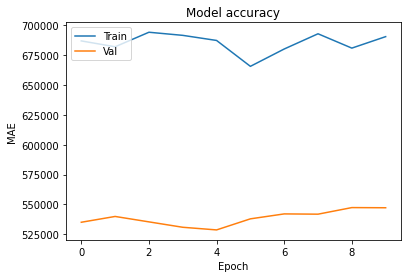

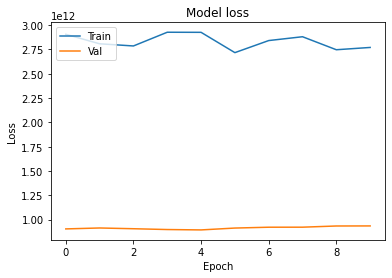

In [0]:
## Visualize model loss

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [0]:
k_model = load_model("model.sve")
k_model.evaluate(np.array(X_test), np.array(y_test))

197/197 [==============================] - 0s 192us/step


[1.116024878113454e+24, 670619729920.0]